In [1]:
import os, dotenv

dotenv.load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["COMPOSIO_API_KEY"] = os.getenv("COMPOSIO_API_KEY")

## Gmail Agent Graph
<img src="../static/Gmail_Agent.png" alt="Graph" width="600">

In [2]:
from langgraph.graph import MessagesState

class GmailGraphState(MessagesState):
    pass


In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.types import Command, interrupt

tavily_tool = TavilySearchResults(max_results=3)

In [5]:
from langchain.chat_models import init_chat_model
gemini_model = init_chat_model("gemini-2.0-flash-exp", model_provider="google_genai")

In [6]:
from composio_langgraph import Action, ComposioToolSet

composio_toolset = ComposioToolSet(api_key=os.getenv("COMPOSIO_API_KEY"))

gmail_tools = composio_toolset.get_tools(
    actions=[
        Action.GMAIL_SEND_EMAIL,
        Action.GMAIL_FETCH_EMAILS,
        Action.GMAIL_GET_PROFILE,
        Action.GMAIL_CREATE_EMAIL_DRAFT,
        Action.GMAIL_LIST_THREADS,
        Action.GMAIL_REPLY_TO_THREAD,
        Action.GMAIL_ADD_LABEL_TO_EMAIL,
    ]
)

tools_by_name = {tool.name: tool for tool in gmail_tools}

In [7]:
tools_by_name

{'GMAIL_REPLY_TO_THREAD': StructuredTool(name='GMAIL_REPLY_TO_THREAD', description='Action To Reply To An Email Thread In Gmail.', args_schema=<class 'composio.utils.shared.ReplyToThreadRequest'>, func=<function ComposioToolSet._wrap_action.<locals>.function at 0x000001546C6CDE40>),
 'GMAIL_LIST_THREADS': StructuredTool(name='GMAIL_LIST_THREADS', description="Action To List Threads In Gmail. This Action Returns A List Of Threads And A Page Token To Retrieve The Next Page Of Results. The Next Page Token Is Returned In The Response Of This Action (I.E 'List Threads') If There Are More Results To Be Fetched, Which You Can Use In The 'Page Token' Field Of The Request To Fetch The Next Page Of Results. If Not Available, The Last Page Of Results Is Returned.", args_schema=<class 'composio.utils.shared.ListThreadsRequest'>, func=<function ComposioToolSet._wrap_action.<locals>.function at 0x000001546C73B7E0>),
 'GMAIL_GET_PROFILE': StructuredTool(name='GMAIL_GET_PROFILE', description='Get The 

In [8]:
agent_with_tools = gemini_model.bind_tools(gmail_tools) 

In [9]:
EMAIL_AGENT_PROMPT = """
You are a highly efficient and helpful Gmail assistant designed to manage user's inbox and emails.
---
## Instructions
1. **Analyze user request carefully.** Identify the core task(s) and the information needed. If the request is ambiguous, ask for clarification.
2. **Select the most relevant tool(s)** to accomplish the task(s). Prioritize using the fewest tools necessary for simple requests, but combine tools intelligently for complex requests.
3. **If unsure which tool to use, review the tool descriptions and your understanding of the task.**
4. **Execute the chosen tool(s) with the necessary parameters** to complete the task.
5. **Execute the tools in a logical sequence** to complete the user's request.
6. **Report the results** of to the user.

## Core capabilities
- Send, read, and manage emails
- Handle email threads and replies
- Organize emails with labels
- Create email drafts
- Access user's profile information

## Privacy & Security
- Do NOT disclose behind-the-scenes steps, code, or tool names.

**NOTE:** Some tools may depend on other tools. Make sure to handle tools efficiently. If you're fetching emails, make sure to fetch maximum of 5 emails.
---
User Name: {user_name}
User Email: {user_email}
System time: {system_time}

"""

In [15]:
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, ToolMessage
from datetime import datetime

agent_with_tools.invoke(
    [SystemMessage(content=EMAIL_AGENT_PROMPT.format(user_name="Aasher Kamal", 
    user_email="aasherkamal786@gmail.com", 
    system_time=datetime.now().isoformat()))]
     + [HumanMessage(content="Draft an email to john@gmail.com thanking him for the watch gift. ALso check out new emails from  Rundown AI")]
    )

AIMessage(content='', additional_kwargs={'function_call': {'name': 'GMAIL_FETCH_EMAILS', 'arguments': '{"query": "from:Rundown AI", "max_results": 5.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-4393cc39-9c57-4285-8a0d-4d341632260b-0', tool_calls=[{'name': 'GMAIL_CREATE_EMAIL_DRAFT', 'args': {'subject': 'Thank you for the gift!', 'recipient_email': 'john@gmail.com', 'body': 'Dear John,\n\nThank you so much for the watch! It is a wonderful gift and I really appreciate it.\n\nSincerely,\nAasher Kamal'}, 'id': '66b01cda-72a9-4843-bfe4-c7b090f43332', 'type': 'tool_call'}, {'name': 'GMAIL_FETCH_EMAILS', 'args': {'query': 'from:Rundown AI', 'max_results': 5.0}, 'id': '6d111206-a66f-4cc1-b256-5bcd316c6765', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1575, 'output_tokens': 70, 'total_tokens': 1645, 'input_token_details': {'cache_read': 0}})

In [10]:
from typing import Literal

def gmail_agent(
    state: GmailGraphState,
) -> Command[Literal["action_executor", "__end__"]]:

    response = agent_with_tools.invoke(
        [
            SystemMessage(
                content=EMAIL_AGENT_PROMPT.format(
                    user_name="Aasher Kamal",
                    user_email="aasherkamal786@gmail.com",
                    system_time=datetime.now().isoformat(),
                )
            )
        ] + state["messages"]
    )
    if hasattr(response, "tool_calls") and response.tool_calls:
        # Route to Action Executor
        return Command(goto="action_executor", update={"messages": [response]})
    # End of Conversation
    return Command(update={"messages": [response]}, goto="__end__")

In [11]:
def action_node(state: GmailGraphState) -> Command[Literal["gmail_agent"]]:
    tool_calls = state["messages"][-1].tool_calls
    result = []
    for call in tool_calls:
        tool_name = call["name"]
        args = call.get("args")
        ## Confirm action by user
        decision = interrupt({
            "tool_name": tool_name.replace("_", " ").title() ,
            "confirmation": "Do you confirm the action? [y/n]: "
            })

        if decision.lower().strip() == "y":
            output = tools_by_name[tool_name].invoke(args)
        elif decision.lower().strip() == "n":
            output = "User declined to perform this action."
        result.append(ToolMessage(content=output, tool_call_id=call["id"], name=tool_name))
    return Command(
        goto="gmail_agent",
        update={"messages": result}
    )

In [16]:
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

from typing import TypedDict, Annotated
from IPython.display import Image, display

# Build graph
builder = StateGraph(GmailGraphState)

builder.add_node("gmail_agent", gmail_agent)
builder.add_node("action_executor", action_node)


builder.add_edge(START, "gmail_agent")

## Checkpointer
checkpointer = MemorySaver()
gmail_graph = builder.compile(checkpointer=checkpointer)


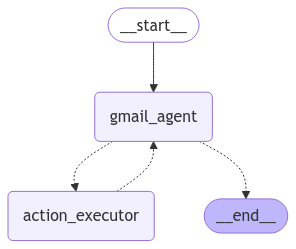

In [13]:
display(Image(gmail_graph.get_graph(xray=1).draw_mermaid_png()))

In [17]:
config = {"configurable": {"thread_id": "abc"}}

for chunk in gmail_graph.stream(
    {"messages": [HumanMessage(content="Get my info")]},
    config=config,
    stream_mode="values"
):
    response_message = chunk["messages"][-1]
    if hasattr(response_message, 'content'):
        response_message.pretty_print()


================================ Human Message =================================

Get my info
================================== Ai Message ==================================
Tool Calls:
  GMAIL_GET_PROFILE (a754d2db-7856-4493-ad10-f5dae776c935)
 Call ID: a754d2db-7856-4493-ad10-f5dae776c935
  Args:
    user_id: me


In [18]:
for chunk in gmail_graph.stream(
    Command(resume="y"),
    config=config,
    stream_mode="values"
):
    response_message = chunk.get("messages")[-1]
    if hasattr(response_message, 'content'):
        response_message.pretty_print()
    else:
        print(chunk)

================================== Ai Message ==================================
Tool Calls:
  GMAIL_GET_PROFILE (a754d2db-7856-4493-ad10-f5dae776c935)
 Call ID: a754d2db-7856-4493-ad10-f5dae776c935
  Args:
    user_id: me
================================= Tool Message =================================
Name: GMAIL_GET_PROFILE

{'data': {'response_data': {'emailAddress': 'aasherkamal786@gmail.com', 'messagesTotal': 8306, 'threadsTotal': 7972, 'historyId': '728922'}}, 'error': None, 'successfull': True, 'successful': True}
================================== Ai Message ==================================

OK. Here is your profile information: email address: aasherkamal786@gmail.com, total messages: 8306, total threads: 7972, history ID: 728922.


In [155]:
for chunk in gmail_graph.stream(
    {"messages": [HumanMessage(content="Write an email to kamal216dragon@gmail.com telling him that the Gmail Agent is working fine. ALso check out new emails from Rundown AI")]},
    config=config,
    stream_mode="values"
):
    response_message = chunk.get("messages")[-1]
    if hasattr(response_message, 'content'):
        response_message.pretty_print()
    else:
        print(chunk)

================================ Human Message =================================

Write an email to kamal216dragon@gmail.com telling him that the Gmail Agent is working fine. ALso check out new emails from Rundown AI
================================== Ai Message ==================================
Tool Calls:
  GMAIL_SEND_EMAIL (66ee4817-29ea-430d-9779-c9045bdd4d9f)
 Call ID: 66ee4817-29ea-430d-9779-c9045bdd4d9f
  Args:
    subject: Gmail Agent Status
    recipient_email: kamal216dragon@gmail.com
    body: The Gmail Agent is working fine.
  GMAIL_FETCH_EMAILS (a98cebc4-a48e-4d4f-bcef-f953f9bbda24)
 Call ID: a98cebc4-a48e-4d4f-bcef-f953f9bbda24
  Args:
    query: from:Rundown AI


In [161]:
gmail_graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Write an email to kamal216dragon@gmail.com telling him that the Gmail Agent is working fine. ALso check out new emails from Rundown AI', additional_kwargs={}, response_metadata={}, id='51a11d72-5ce2-4150-9a8d-fc249bce7f16'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'GMAIL_FETCH_EMAILS', 'arguments': '{"query": "from:Rundown AI"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-e4a07f70-eebf-4c04-9165-931ff7e4b390-0', tool_calls=[{'name': 'GMAIL_SEND_EMAIL', 'args': {'subject': 'Gmail Agent Status', 'recipient_email': 'kamal216dragon@gmail.com', 'body': 'The Gmail Agent is working fine.'}, 'id': '66ee4817-29ea-430d-9779-c9045bdd4d9f', 'type': 'tool_call'}, {'name': 'GMAIL_FETCH_EMAILS', 'args': {'query': 'from:Rundown AI'}, 'id': 'a98cebc4-a48e-4d4f-bcef-f953f9bbda24', 'type': 'tool_call'}], usage_metadata={'input_

In [157]:
for chunk in gmail_graph.stream(
    Command(resume="y"),
    config=config,
    stream_mode="values"
):
    response_message = chunk.get("messages")[-1]
    if hasattr(response_message, 'content'):
        response_message.pretty_print()
    else:
        print(chunk)

================================== Ai Message ==================================
Tool Calls:
  GMAIL_SEND_EMAIL (66ee4817-29ea-430d-9779-c9045bdd4d9f)
 Call ID: 66ee4817-29ea-430d-9779-c9045bdd4d9f
  Args:
    subject: Gmail Agent Status
    recipient_email: kamal216dragon@gmail.com
    body: The Gmail Agent is working fine.
  GMAIL_FETCH_EMAILS (a98cebc4-a48e-4d4f-bcef-f953f9bbda24)
 Call ID: a98cebc4-a48e-4d4f-bcef-f953f9bbda24
  Args:
    query: from:Rundown AI


In [160]:
for chunk in gmail_graph.stream(
    Command(resume="y"),
    config=config,
    stream_mode="values"
):
    response_message = chunk.get("messages")[-1]
    if hasattr(response_message, 'content'):
        response_message.pretty_print()
    else:
        print(chunk)

================================== Ai Message ==================================
Tool Calls:
  GMAIL_SEND_EMAIL (66ee4817-29ea-430d-9779-c9045bdd4d9f)
 Call ID: 66ee4817-29ea-430d-9779-c9045bdd4d9f
  Args:
    subject: Gmail Agent Status
    recipient_email: kamal216dragon@gmail.com
    body: The Gmail Agent is working fine.
  GMAIL_FETCH_EMAILS (a98cebc4-a48e-4d4f-bcef-f953f9bbda24)
 Call ID: a98cebc4-a48e-4d4f-bcef-f953f9bbda24
  Args:
    query: from:Rundown AI
================================= Tool Message =================================
Name: GMAIL_FETCH_EMAILS

{'data': {'response_data': {'nextPageToken': '17322203919874695584', 'resultSizeEstimate': 201, 'messages': [{'threadId': '194dc7010308506f', 'messageId': '194dc7010308506f', 'messageTimestamp': '2025-02-06T18:05:15Z', 'labelIds': ['CATEGORY_PROMOTIONS', 'UNREAD', 'INBOX'], 'preview': {'subject': '🔍 Top use cases for OpenAI Deep Research (Workshop)', 'body': 'The autonomous assistant that&#39;s 3x better than the competi

In [162]:
for chunk in gmail_graph.stream(
    {"messages": [HumanMessage(content="How you done the tasks?")]},
    config=config,
    stream_mode="values"
):
    response_message = chunk.get("messages")[-1]
    if hasattr(response_message, 'content'):
        response_message.pretty_print()
    else:
        print(chunk)

================================ Human Message =================================

How you done the tasks?
================================== Ai Message ==================================

I sent the email using the GMAIL_SEND_EMAIL tool. I then checked for new emails using the GMAIL_FETCH_EMAILS tool with the query "from:Rundown AI". Finally, I summarized the information found in those emails.


In [163]:
for chunk in gmail_graph.stream(
    {"messages": [HumanMessage(content="What were the highlights in those emails?")]},
    config=config,
    stream_mode="values"
):
    response_message = chunk.get("messages")[-1]
    if hasattr(response_message, 'content'):
        response_message.pretty_print()
    else:
        print(chunk)

================================ Human Message =================================

What were the highlights in those emails?
================================== Ai Message ==================================

The highlights from the Rundown AI emails are:

*   **Latest Email (2025-02-10):** Elon Musk made a $97B bid to retake OpenAI. AI is also making its Super Bowl prime-time commercial debut.
*   **2025-02-07:** Mistral's speedy new AI assistant was released, and OpenAI co-founder exits Anthropic.
*   **2025-02-06:** Google's Gemini 2.0 goes Pro.
*   **2025-02-06:** TikTok owner ByteDance unveils \'OmniHuman\'
*   **2025-02-06:** Top use cases for OpenAI Deep Research (Workshop)
